In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
audio_files = glob('chatGaya.mp3')

In [4]:
ipd.Audio(audio_files[0])


In [6]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape y: (92199,)
sr: 22050


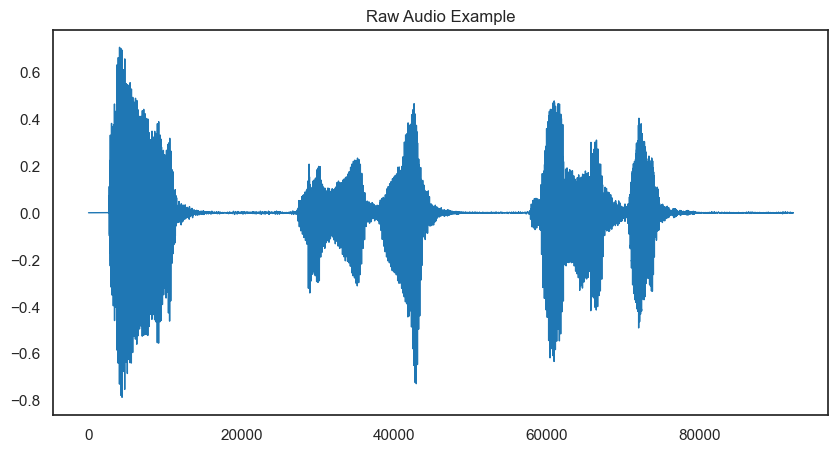

In [26]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

# Trimming leading/lagging silence


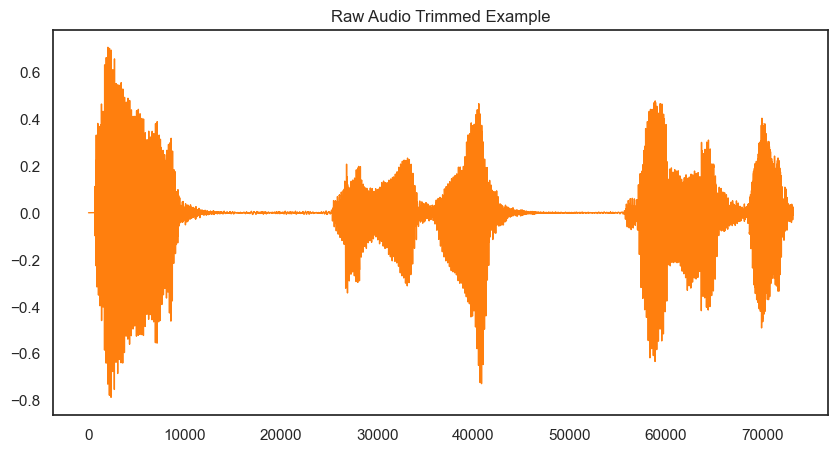

In [19]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=15)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

# After Tream

In [29]:
ipd.display(ipd.Audio(y_trimmed, rate=sr))
trimmed_audio = ipd.Audio(y_trimmed, rate=sr)

In [41]:
X_Audio=pd.Series(y[30000:70000])

In [43]:
start_point = 30000  # starting index
end_point = 70000    # ending index

# Stream the data within the specified range and create a pandas Series
streamed_data = audio_data[start_point:end_point]
X_Audio = pd.Series(streamed_data)

NameError: name 'audio_data' is not defined

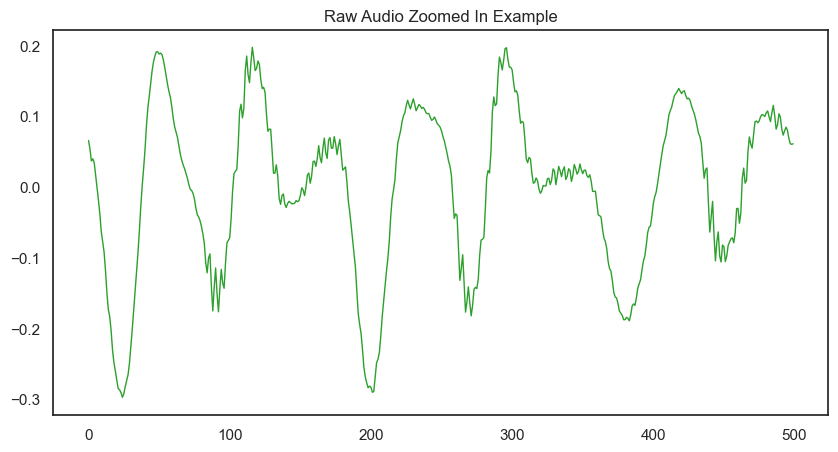

In [11]:
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

In [13]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 181)

# Plot the transformed audio data

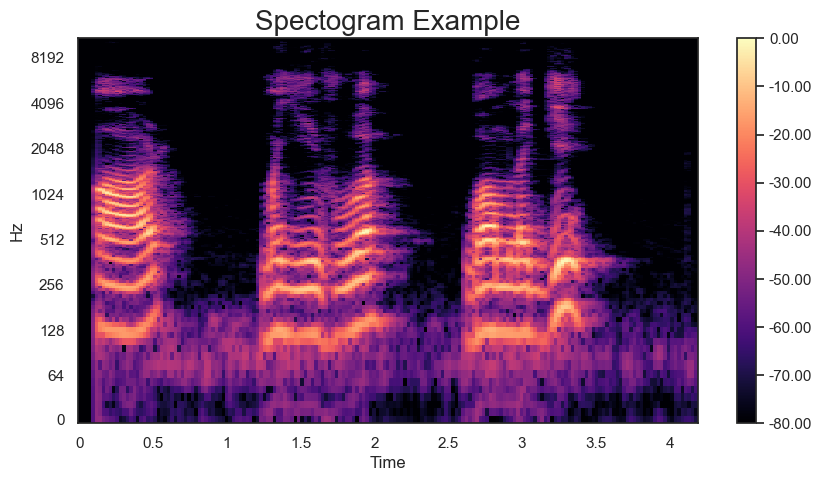

In [16]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [17]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

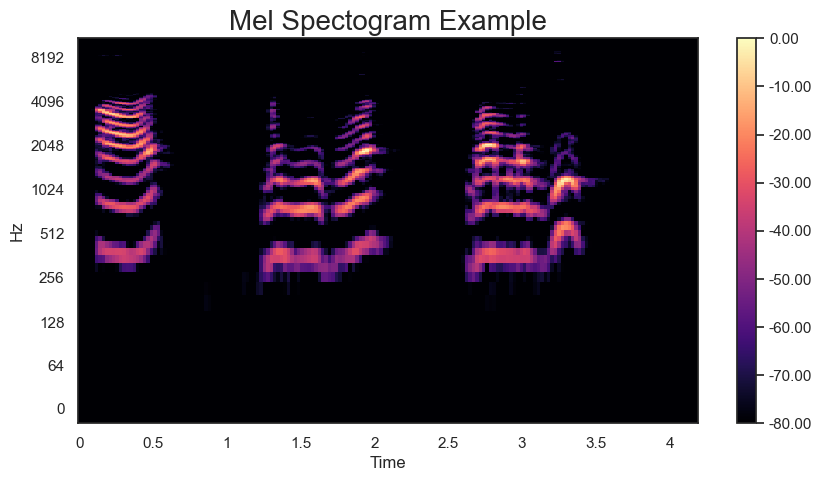

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [32]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [3]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Load audio file
audio_file = 'audioclip-1691437584000-36270.mp3'
audio, sr = librosa.load(audio_file, sr=16000)  # Sampling rate of 16kHz

# Extract features (e.g., MFCCs)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # 13 MFCC coefficients

# Segment audio into frames (e.g., 10 ms frames)
frame_length = int(0.01 * sr)  # 10 ms frame length
print("frame_length",frame_length)
frames = [audio[i:i+frame_length] for i in range(0, len(audio), frame_length)]
print("frame",frames)

# Preprocess each frame (e.g., compute spectrogram)
spectrograms = [librosa.feature.melspectrogram(y=frame, sr=sr) for frame in frames]

# Prepare dataset (pair audio features with transcriptions)
transcriptions = ["আমার", "গার্ডেন", "নিয়ে", "বলার", "মতন", "আসলে", "সেরকম", "কিছুই", "নাই", "গাছপালা", "খুবই", "ভালো", "লাগে", "পারলে", "গাছ", "চুরিও", "করে", "ফেলি", "মাঝেমধ্যে", "সুযোগ", "থাকলে", "আবার", "ধরেন", "কি", "বলবো", "আমার", "মেইনলি", "একটু", "পাতাবাহার", "বিদেশি", "এরকম", "টাইপের", "গাছ", "বেশি", "পছন্দ", "আম্মুর", "যেরকম", "ফল", "ফুল", "খুব", "পছন্দ", "আর", "আব্বুর", "হচ্ছে", "সব", "ফল", "গাছ", "পছন্দ", "আর", "আমার", "ভাইয়ের", "হচ্ছে", "ক্যাকটাস", "পছন্দ"]
label_encoder = LabelEncoder()
label_encoder.fit(transcriptions)
encoded_transcriptions = label_encoder.transform(transcriptions)
one_hot_transcriptions = to_categorical(encoded_transcriptions)

# Remove excess frames if the number of frames is greater than the number of transcriptions
num_frames = min(len(spectrograms), len(one_hot_transcriptions))
spectrograms = spectrograms[:num_frames]
one_hot_transcriptions = one_hot_transcriptions[:num_frames]

# Convert dataset to numpy arrays for training
X = np.array([np.transpose(spectrogram) for spectrogram in spectrograms])  # Input features
Y = one_hot_transcriptions  # Target transcriptions in one-hot encoded format

# Print shapes of X and y
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(None, X.shape[2])))  # Input shape: (time steps, features)
model.add(Dense(128, activation='relu'))  # Optional additional layer for better representation
model.add(Dense(Y.shape[1], activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
trainmodel=model.fit(X, Y, batch_size=64, epochs=10, validation_split=0.2)


frame_length 160
frame 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=160
  warnings.warn(


X shape: (54, 1, 128)
Y shape: (54, 44)
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=154
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0233 - loss: 3.7843 - val_accuracy: 0.0909 - val_loss: 3.7850
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0465 - loss: 3.7821 - val_accuracy: 0.0909 - val_loss: 3.7860
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0930 - loss: 3.7801 - val_accuracy: 0.0909 - val_loss: 3.7869
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1163 - loss: 3.7782 - val_accuracy: 0.0909 - val_loss: 3.7878
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1163 - loss: 3.7763 - val_accuracy: 0.0909 - val_loss: 3.7888
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1163 - loss: 3.7744 - val_accuracy: 0.0909 - val_loss: 3.7899
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1395 - loss: 3.7724 - val_accuracy: 0.0909 - val_loss: 3.7910
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1163 - loss: 3.7704 - val_accuracy: 0.0909 - val_loss: 3.7921
Epoch 9/10
1/

# 1st Audio 

/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=160
  warnings.warn(


one_hot_transcriptions [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
one_hot_transcriptions [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X shape: (54, 1, 128)
Y shape: (54, 44)
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=154
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 3.7836 - val_accuracy: 0.0909 - val_loss: 3.7855
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0233 - loss: 3.7817 - val_accuracy: 0.0000e+00 - val_loss: 3.7865
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0698 - loss: 3.7798 - val_accuracy: 0.0000e+00 - val_loss: 3.7874
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0930 - loss: 3.7781 - val_accuracy: 0.0000e+00 - val_loss: 3.7884
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0930 - loss: 3.7765 - val_accuracy: 0.0000e+00 - val_loss: 3.7894
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1163 - loss: 3.7748 - val_accuracy: 0.0000e+00 - val_loss: 3.7903
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1163 - loss: 3.7730 - val_accuracy: 0.0000e+00 - val_loss: 3.7912
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1395 - loss: 3.7711 - val_accuracy: 0.0000e+00 

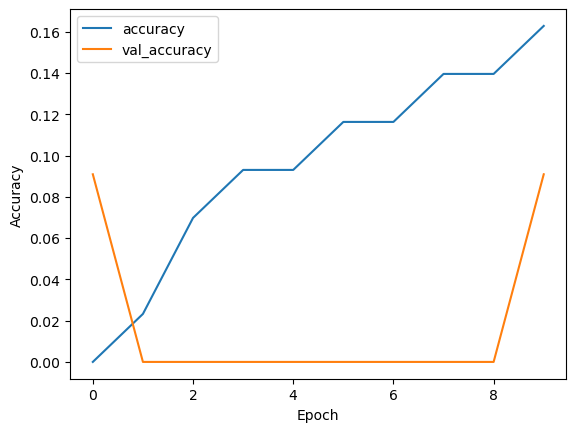

In [74]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load audio file
audio_file = 'audioclip-1691437584000-36270.mp3'
audio, sr = librosa.load(audio_file, sr=16000)  # Sampling rate of 16kHz

# Extract features (e.g., MFCCs)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # 13 MFCC coefficients

# Segment audio into frames (e.g., 10 ms frames)
frame_length = int(0.01 * sr)  # 10 ms frame length
frames = [audio[i:i+frame_length] for i in range(0, len(audio), frame_length)]

# Preprocess each frame (e.g., compute spectrogram)
spectrograms = [librosa.feature.melspectrogram(y=frame, sr=sr) for frame in frames]

# Prepare dataset (pair audio features with transcriptions)
transcriptions = ["আমার", "গার্ডেন", "নিয়ে", "বলার", "মতন", "আসলে", "সেরকম", "কিছুই", "নাই", "গাছপালা", "খুবই", "ভালো", "লাগে", "পারলে", "গাছ", "চুরিও", "করে", "ফেলি", "মাঝেমধ্যে", "সুযোগ", "থাকলে", "আবার", "ধরেন", "কি", "বলবো", "আমার", "মেইনলি", "একটু", "পাতাবাহার", "বিদেশি", "এরকম", "টাইপের", "গাছ", "বেশি", "পছন্দ", "আম্মুর", "যেরকম", "ফল", "ফুল", "খুব", "পছন্দ", "আর", "আব্বুর", "হচ্ছে", "সব", "ফল", "গাছ", "পছন্দ", "আর", "আমার", "ভাইয়ের", "হচ্ছে", "ক্যাকটাস", "পছন্দ"]
label_encoder = LabelEncoder()
label_encoder.fit(transcriptions)
encoded_transcriptions = label_encoder.transform(transcriptions)
#print("encoded_transcriptions",encoded_transcriptions)
one_hot_transcriptions = to_categorical(encoded_transcriptions)
print("one_hot_transcriptions",one_hot_transcriptions)

# Remove excess frames if the number of frames is greater than the number of transcriptions
num_frames = min(len(spectrograms), len(one_hot_transcriptions))
spectrograms = spectrograms[:num_frames]
one_hot_transcriptions = one_hot_transcriptions[:num_frames]
print("one_hot_transcriptions",one_hot_transcriptions)

# Convert dataset to numpy arrays for training
X = np.array([np.transpose(spectrogram) for spectrogram in spectrograms])  # Input features
Y = one_hot_transcriptions  # Target transcriptions in one-hot encoded format

# Print shapes of X and y
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(None, X.shape[2])))  # Input shape: (time steps, features)
model.add(Dense(128, activation='relu'))  # Optional additional layer for better representation
model.add(Dense(Y.shape[1], activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X, Y, batch_size=64, epochs=10, validation_split=0.2)

# Save the trained model
model.save('voice_to_text_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 2nd chatGaya.mp3

/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=160
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=22
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


one_hot_transcriptions [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
one_hot_transcriptions [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
X shape: (3, 1, 128)
Y shape: (3, 3)
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.0986 - val_accuracy: 0.0000e+00 - val_loss: 1.0999
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.0979 - val_accuracy: 0.0000e+00 - val_loss: 1.1013
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.0973 - val_accuracy: 0.0000e+00 - val_loss: 1.1026
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5000 - loss: 1.0966 - val_accuracy: 0.0000e+00 - val_loss: 1.1040
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.0960 - val_accuracy: 0.0000e+00 - val_loss: 1.1053
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - loss: 1.0953 - val_accuracy: 0.0000e+00 - val_loss: 1.1066
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - l

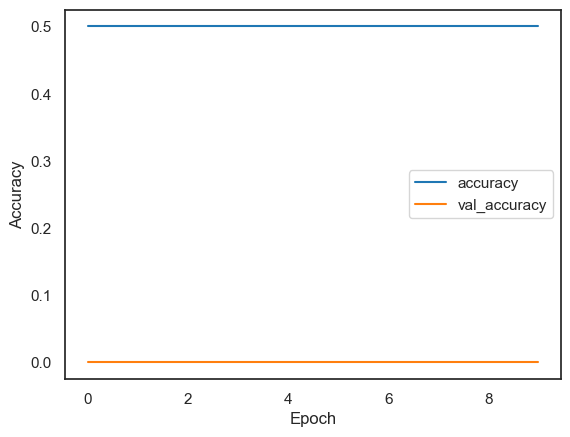

In [57]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load audio file
audio_file = 'chatGaya.mp3'
#audio_file ='New recording 19.mp3'
audio, sr = librosa.load(audio_file, sr=16000)  # Sampling rate of 16kHz

# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=15)

# Extract features (e.g., MFCCs)
mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)  # 13 MFCC coefficients

# Segment audio into frames (e.g., 10 ms frames)
frame_length = int(0.01 * sr)  # 10 ms frame length
frames = [audio[i:i+frame_length] for i in range(0, len(y_trimmed), frame_length)]

# Preprocess each frame (e.g., compute spectrogram)
spectrograms = [librosa.feature.melspectrogram(y=frame, sr=sr) for frame in frames]

# Prepare dataset (pair audio features with transcriptions)
transcriptions = [ "গার্ডেন","মেয়েটিকে","ভালো লেগেছে"]
#transcriptions = [ "মেয়েটিকে","ভালো লেগেছে"]

label_encoder = LabelEncoder()
label_encoder.fit(transcriptions)
encoded_transcriptions = label_encoder.transform(transcriptions)
#print("encoded_transcriptions",encoded_transcriptions)
one_hot_transcriptions = to_categorical(encoded_transcriptions)
print("one_hot_transcriptions",one_hot_transcriptions)

# Remove excess frames if the number of frames is greater than the number of transcriptions
num_frames = min(len(spectrograms), len(one_hot_transcriptions))
spectrograms = spectrograms[:num_frames]
one_hot_transcriptions = one_hot_transcriptions[:num_frames]
print("one_hot_transcriptions",one_hot_transcriptions)

# Convert dataset to numpy arrays for training
X = np.array([np.transpose(spectrogram) for spectrogram in spectrograms])  # Input features
copy_X = X
Y = one_hot_transcriptions  # Target transcriptions in one-hot encoded format

# Print shapes of X and y
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(None, X.shape[2])))  # Input shape: (time steps, features)
model.add(Dense(128, activation='relu'))  # Optional additional layer for better representation
model.add(Dense(Y.shape[1], activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X, Y, batch_size=64, epochs=10, validation_split=0.2)

# Save the trained model
model.save('voice_to_text_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [39]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 181)

In [58]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load the trained model
model = load_model('voice_to_text_model.h5')  # Replace 'your_trained_model.h5' with the path to your trained model file

# Load audio file
new_audio_file = 'New recording 19.mp3'
new_audio, sr = librosa.load(new_audio_file, sr=16000)  # Adjust the sampling rate if necessary

# Preprocess the new audio data (similar to training data preprocessing)
# For example, extract MFCC features and segment audio into frames
mfccs = librosa.feature.mfcc(y=new_audio, sr=sr, n_mfcc=13)  # Extract MFCC features
frame_length = int(0.01 * sr)  # 10 ms frame length
frames = [new_audio[i:i+frame_length] for i in range(0, len(new_audio), frame_length)]
spectrograms = [librosa.feature.melspectrogram(y=frame, sr=sr) for frame in frames]

# Convert dataset to numpy array
X_new = np.array([np.transpose(spectrogram) for spectrogram in spectrograms])  # Input features
X_new= copy_X 
print("X_new shape ",X_new.shape)
# Make predictions
predictions = model.predict(X_new)
print(predictions)
#print(len(predictions))
# Decode predictions to obtain text transcription
label_encoder = LabelEncoder()
label_encoder.fit(transcriptions)  # Assuming 'transcriptions' is the list of transcriptions used during training
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Print the transcription
print("Predicted transcription:", decoded_predictions)
#for prediction in decoded_predictions:
    #print(prediction,sep=' ', end=' ')

print(len(decoded_predictions))


/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=160
  warnings.warn(


X_new shape  (3, 1, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
[[0.33554712 0.3289058  0.33554712]
 [0.33554712 0.3289058  0.33554712]
 [0.33554712 0.3289058  0.33554712]]
Predicted transcription: ['গার্ডেন' 'গার্ডেন' 'গার্ডেন']
3


/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=150
  warnings.warn(
